In [80]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [81]:
data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']

In [82]:
data.loc[data.isna().any(axis='columns')]
data.dropna(axis='index', inplace=True)

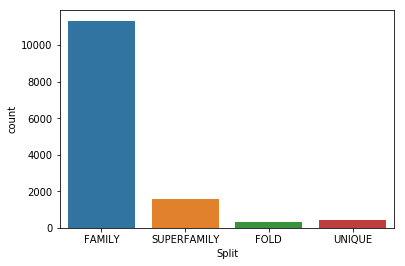

In [83]:
sns.countplot(data=split, x='Split')

In [84]:
family = data[data['Label'].isin(['Fam', 'Random'])]

In [ ]:
sns.pairplot(data[feature_names + ['Label']], hue='Label', diag_kind='kde', plot_kws={'s': 10, 'alpha': 0.5})

In [96]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']
proteins = np.unique(family['Target'].values)
np.random.seed(42)
sample = np.random.choice(proteins, size=2000, replace=False)
train = sample[:1800]
test = sample[1800:]

In [86]:
X_train = family[family['Target'].isin(train)][feature_names].values
X_test = family[family['Target'].isin(test)][feature_names].values
y_train = family[family['Target'].isin(train)]['Label'].replace({'Random': 0, 'Fam': 1, 'SFam': 2, 'Fold': 3}).values.ravel()
y_test = family[family['Target'].isin(test)]['Label'].replace({'Random': 0, 'Fam': 1, 'SFam': 2, 'Fold': 3}).values.ravel()

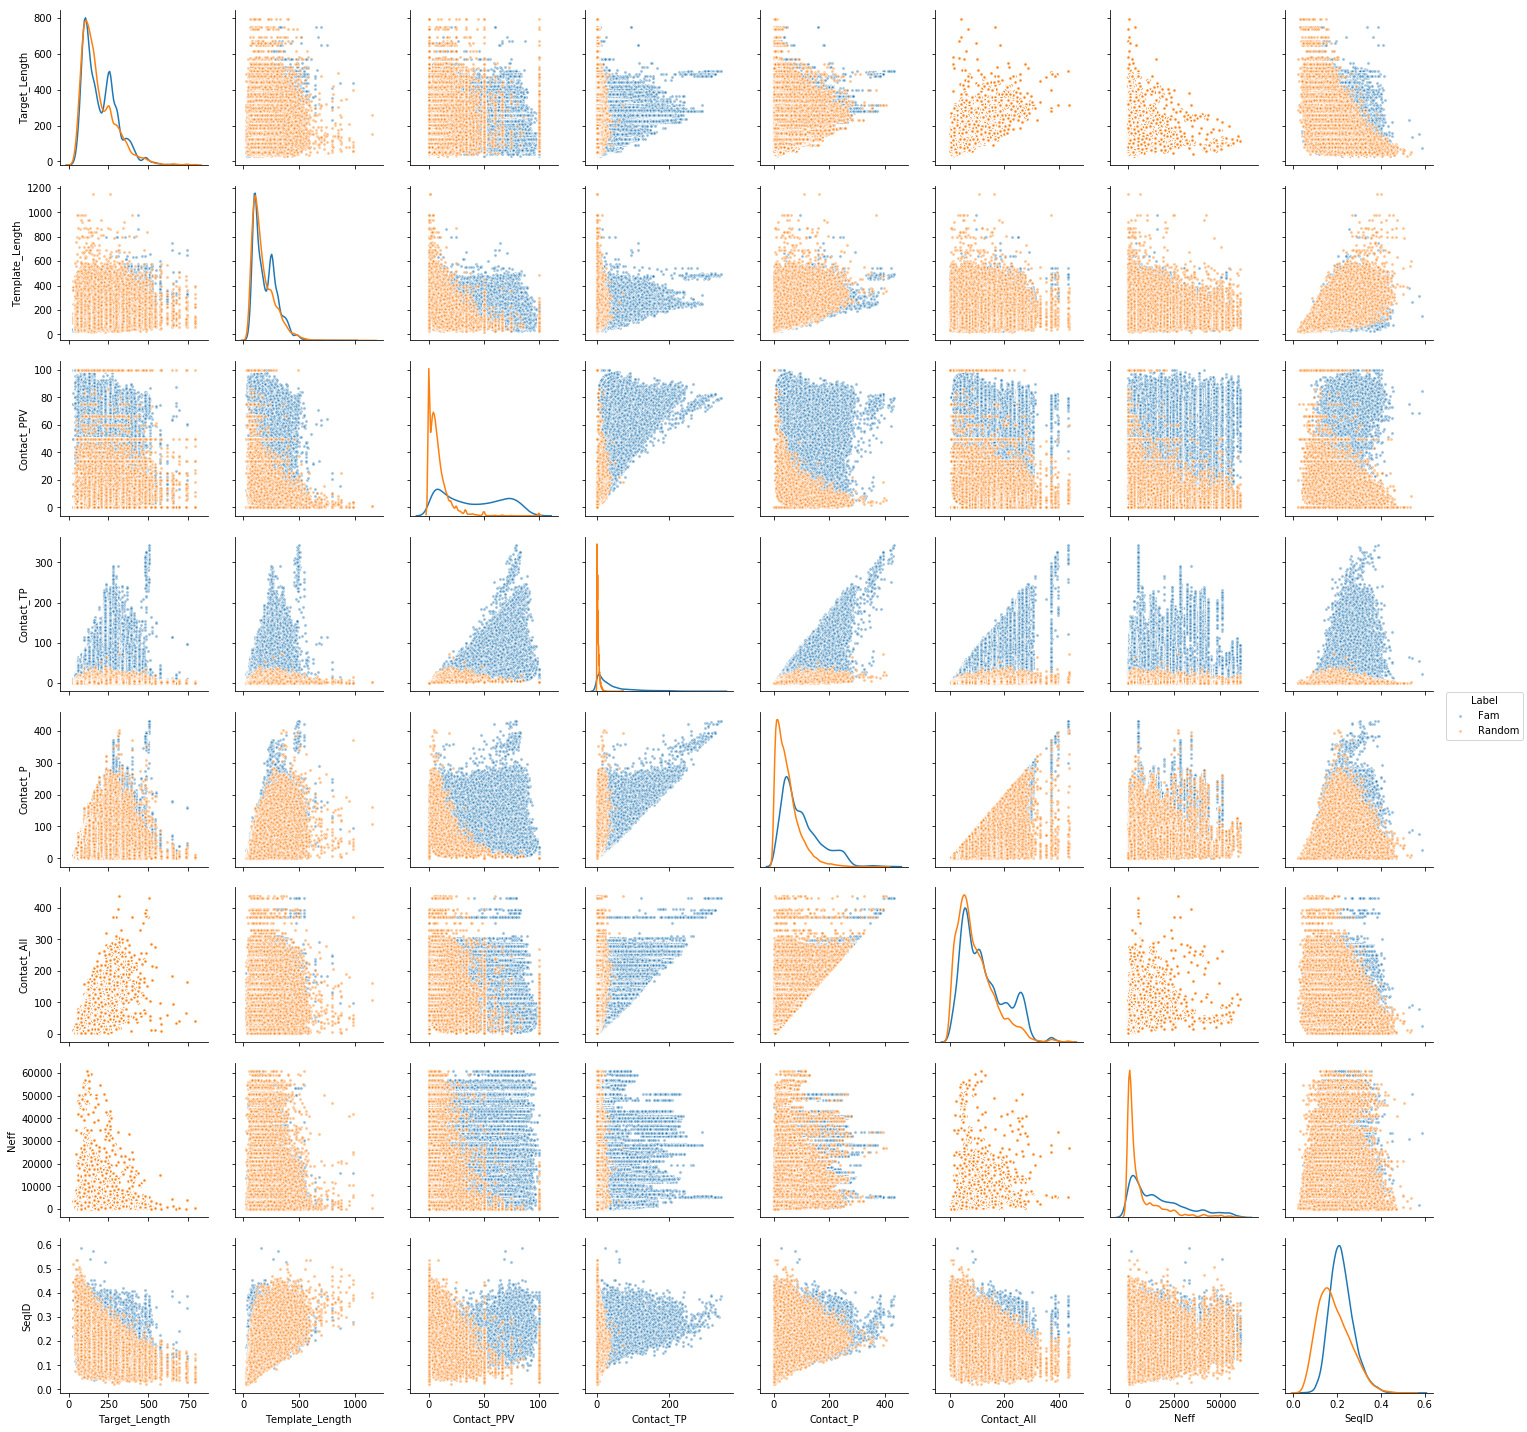

In [105]:
feats = family[family['Target'].isin(train)]
feats = feats[feature_names + ['Label']]
sns.pairplot(feats, hue='Label', diag_kind='kde', plot_kws={'s': 10, 'alpha': 0.5})

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [26]:
rf.classes_

array([0, 1])

In [51]:
y_pred = rf.predict(X_test)
y_score_oob = [p[1] for p in rf.oob_decision_function_]
y_pred_oob = [round(p) for p in y_score_oob]
y_score_test = [p[1] for p in rf.predict_proba(X_test)]

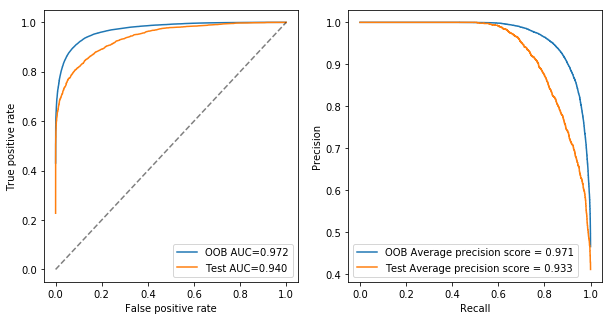

In [69]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fpr, tpr, _ = roc_curve(y_train, y_score_oob)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'OOB AUC={roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_train, y_score_oob)
pr_score = average_precision_score(y_train, y_score_oob)
ax2.step(recall, precision, label=f'OOB Average precision score = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Test AUC={roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_test, y_score_test)
pr_score = average_precision_score(y_test, y_score_test)
ax2.step(recall, precision,  label=f'Test Average precision score = {pr_score:.3f}')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend()

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

0.8700496913115494

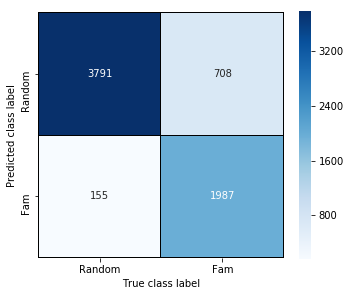

In [70]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).T
cm.rename({0: 'Random', 1: 'Fam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'Fam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_test, y_test)

0.9126478053612332

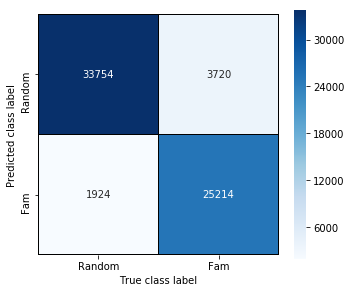

In [71]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred_oob)).T
cm.rename({0: 'Random', 1: 'Fam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'Fam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.oob_score_